# Cadence Effects

This notebook simulates normal Type Ia Supernova (SN Ia) light-curves using realistic cadences and atmospheric variabilities expected from LSST.


In [1]:
import sys
sys.path.insert(0, '../')

import sncosmo
from astropy.io import fits
from astropy.table import Table
from matplotlib import pyplot as plt
from pwv_kpno.package_settings import ConfigBuilder, settings
from pwv_kpno import pwv_atm

from sn_analysis import filters
from sn_analysis import plasticc
from sn_analysis import plotting

filters.register_lsst_filters(force=True)


../sn_analysis/plasticc.py:23: UserWarning: ``plasticc_sim_dir`` is not set in environment. Defaulting to /mnt/md0/snsims
  warn(f'``plasticc_sim_dir`` is not set in environment. Defaulting to {default_data_dir}')


In [2]:
plt.rcParams['figure.dpi'] = 100


## Atmospheric Variability

To create a physically reasonable representation of the atmospheric variability at LSST, we use PWV measurements taken at the nearby Cerro Telolo International Observatory (CTIO).


In [3]:
ctio_config = ConfigBuilder(
    site_name='cerro_tololo',
    primary_rec='CTIO',
    sup_rec=[]
)

ctio_config.save_to_ecsv('./cerro_tololo.ecsv', overwrite=True)
settings.import_site_config('./cerro_tololo.ecsv', overwrite=True)
settings.set_site('cerro_tololo')


In [4]:
pwv_atm.update_models(range(2012, 2019))


[2012, 2013, 2014, 2015, 2016, 2017, 2018]

(0.0, 20.0)

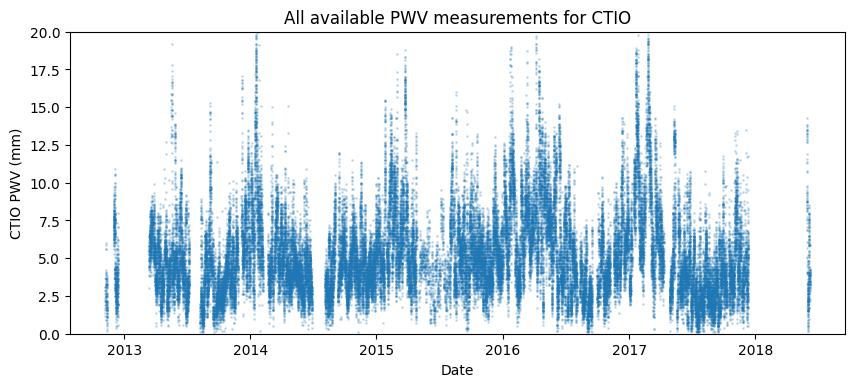

In [5]:
ctio_pwv = pwv_atm.measured_pwv().to_pandas('date')

ctio_pwv.reset_index().plot.scatter('date', 'CTIO', s=1, figsize=(10, 4), alpha=.2)
plt.ylabel('CTIO PWV (mm)')
plt.xlabel('Date')
plt.title('All available PWV measurements for CTIO')
plt.ylim(0, 20)


We don't have enough data to fully represent a 10 year long survey. Fortunately we are mostly interested in timescales of seasonal variability and shorter so we can consider data from a single year with good measurement coverage. 

Winter Average:  7.13 +\-  2.90 mm
Spring Average:  7.44 +\-  3.18 mm
Summer Average:  4.07 +\-  5.06 mm
Fall Average:   5.07 +\-  4.91 mm


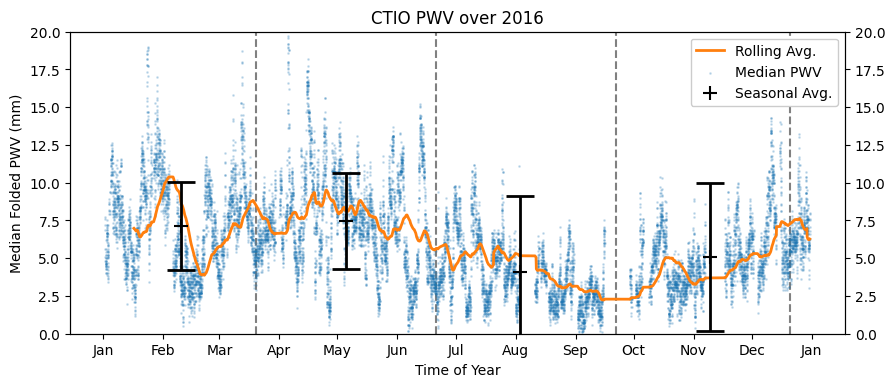

In [6]:
plotting.plot_year_pwv_vs_time(ctio_pwv[ctio_pwv.index.year == 2016].CTIO)
plt.title('CTIO PWV over 2016');


Out of simple curiosity, we also visualize the median PWV across all available years.


In [7]:
good_pwv_data = ctio_pwv[ctio_pwv.CTIO <= 25]
good_pwv_data.index = good_pwv_data.index.map(lambda t: t.replace(year=2000))  # Use a dummy year
folded_pwv = good_pwv_data.groupby(good_pwv_data.index).CTIO.median()


Winter Average:  6.87 +\-  1.85 mm
Spring Average:  5.07 +\-  1.36 mm
Summer Average:  3.69 +\-  1.21 mm
Fall Average:   4.45 +\-  1.02 mm


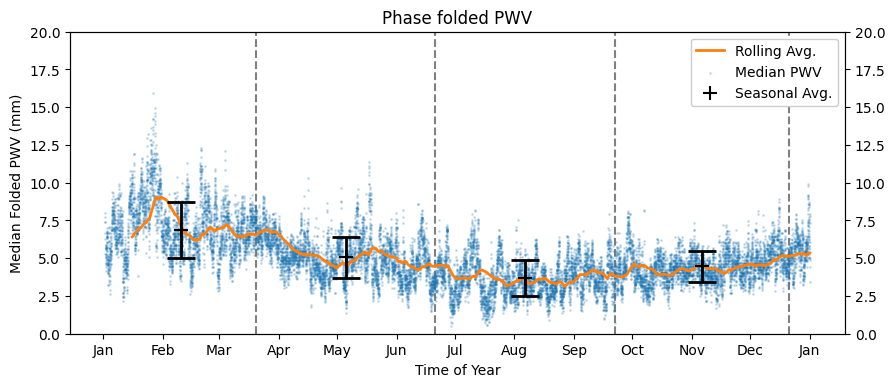

In [8]:
plotting.plot_year_pwv_vs_time(folded_pwv)
plt.title('Phase folded PWV');


## The PLaSTICC Data

Instead of evaluating different cadences from scratch, we use light-curves from the PLaSTICC simulations. First we check what cadence simulations are available on the notebook's host server.


In [9]:
plasticc.get_available_cadences()


['alt_sched_rolling',
 'rolling_mix_10yrs_opsim',
 'kraken_2026',
 'rolling_10yrs_opsim',
 'alt_sched',
 'nexus_2097']

Simulated light-curves are written in the SNANA file format and are distributed across multiple files. We load a light-curve from one of these files and demosntrate the data model below. Each cadence includes simulations run with multiple supernova models. In this notebook we only need simulations for normal SNe (Model 11). 


In [10]:
demo_cadence = 'alt_sched_rolling'
demo_cadence_header_files = plasticc.get_model_headers('alt_sched_rolling', 11)

demo_header_path = demo_cadence_header_files[0]
with fits.open(demo_header_path) as _temp:
    light_curves_per_file = len(_temp[1].data) 

print('Files per cadence:', len(demo_cadence_header_files))
print('Max light-curves per file:', light_curves_per_file)
    

Files per cadence: 40
Max light-curves per file: 81332


In [11]:
plasticc_lc = next(plasticc.iter_lc_for_header(demo_header_path, verbose=False))


In [12]:
plasticc_lc.meta


OrderedDict([('SUBSURVEY', '                                        '),
             ('SNID', '8153737         '),
             ('IAUC', 'NULL            '),
             ('FAKE', 2),
             ('RA', 253.055557),
             ('DECL', -60.056278),
             ('PIXSIZE', 0.20000000298023224),
             ('NXPIX', -9),
             ('NYPIX', -9),
             ('CCDNUM', 0),
             ('SNTYPE', 111),
             ('NOBS', 199),
             ('PTROBS_MIN', 1),
             ('PTROBS_MAX', 199),
             ('MWEBV', 0.15503360331058502),
             ('MWEBV_ERR', 0.007751679979264736),
             ('REDSHIFT_HELIO', 0.5014199614524841),
             ('REDSHIFT_HELIO_ERR', 0.23810000717639923),
             ('REDSHIFT_FINAL', 0.5016952753067017),
             ('REDSHIFT_FINAL_ERR', 0.23810000717639923),
             ('VPEC', 0.0),
             ('VPEC_ERR', 300.0),
             ('HOSTGAL_OBJID', 277268),
             ('HOSTGAL_PHOTOZ', 0.5014199614524841),
             ('HOSTGA

In [13]:
plasticc_lc


MJD,FLT,FIELD,PHOTFLAG,PHOTPROB,FLUXCAL,FLUXCALERR,PSF_SIG1,SKY_SIG,ZEROPT,SIM_MAGOBS
float64,str2,str12,int32,float32,float32,float32,float32,float32,float32,float32
60750.3891,z,NULL,0,0.0,-9.732752,18.38342,1.72,59.76,30.97,98.75439
60750.4025,Y,NULL,0,0.0,41.852177,45.757626,1.91,57.62,30.02,98.79263
60751.3921,z,NULL,0,0.0,19.945679,18.32146,1.75,57.91,30.96,98.75439
60751.4056,Y,NULL,0,0.0,-20.76702,38.440018,1.5,61.71,30.02,98.79263
60752.3933,z,NULL,0,0.0,15.96132,14.578538,1.4,58.11,30.97,98.75439
60752.407,Y,NULL,0,0.0,-5.417403,42.153595,1.6,64.03,30.03,98.79263
60753.3966,Y,NULL,0,0.0,-8.590908,19.21085,1.2,77.63,30.78,98.79263
60754.3856,r,NULL,0,0.0,-21.428425,9.080835,1.41,55.73,31.61,98.57609
60754.3973,z,NULL,0,0.0,-1.4168533,11.824018,1.23,53.75,30.97,98.75439


Here we reformat the data to be compatible with `sncosmo` so we can easily visualize the light-curve.


In [14]:
formatted_lc = plasticc.format_plasticc_sncosmo(plasticc_lc)


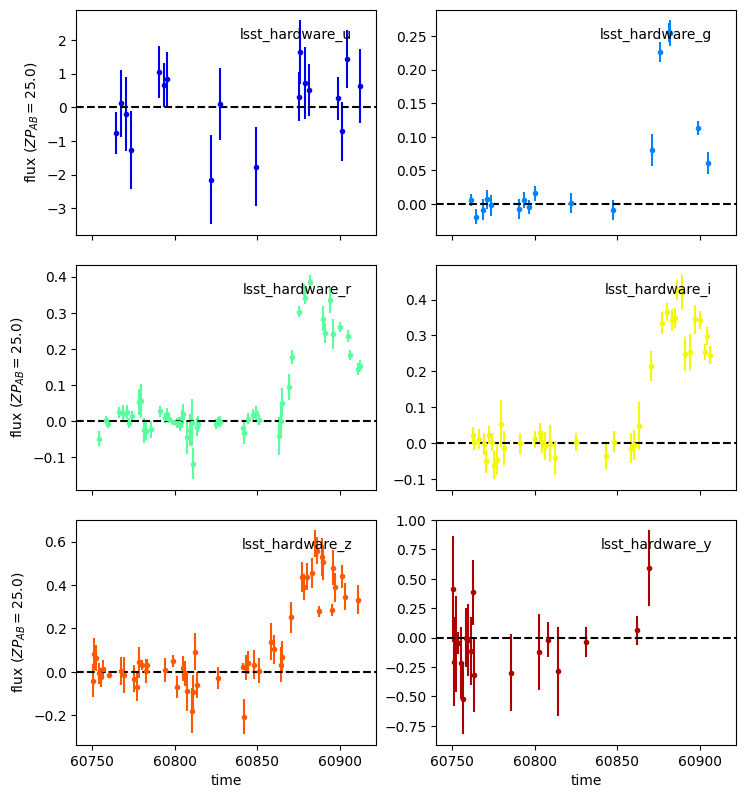

In [15]:
sncosmo.plot_lc(formatted_lc);


## Simulating Light-Curves

Since we need to add in our own atmospheric variability, the pre-tabulated flux values above are of limited use. Instead, we use the PLaSTICC light-curves to establish the cadence and model parameters for each simulated SN. This information is then used to simulate our own light-curves with `sncosmo`.


In [16]:
duplicated_lc = plasticc.duplicate_plasticc_sncosmo(
    plasticc_lc, gain=20, skynr=100)


In [17]:
duplicated_lc.meta


{'t0': 60886.64453125,
 'x1': 1.444517970085144,
 'c': -0.08624675124883652,
 'z': 0.5011050701141357,
 'x0': 8.156622746263912e-06}

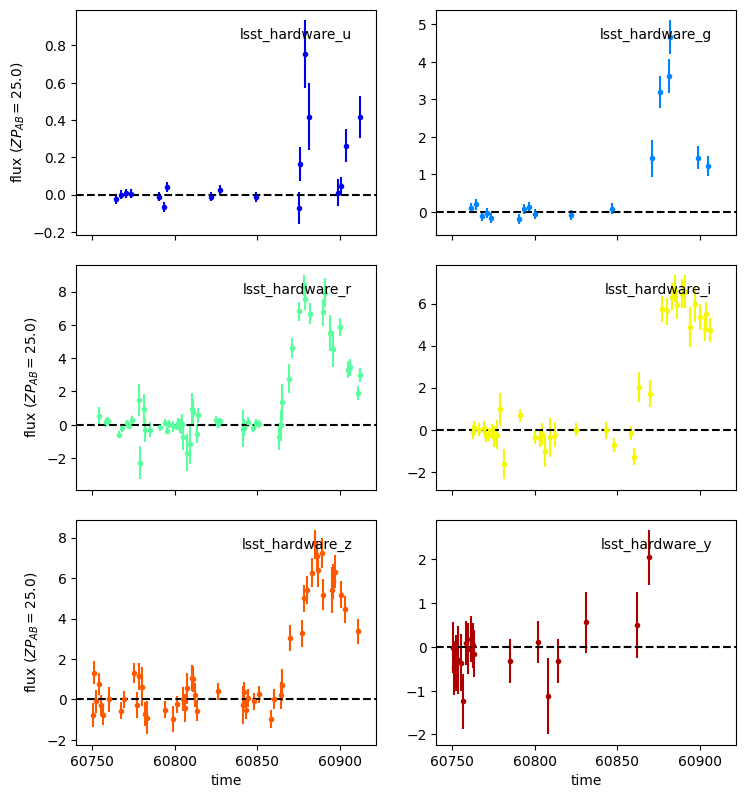

In [18]:
sncosmo.plot_lc(duplicated_lc);


In [19]:
duplicated_lc


time,band,flux,fluxerr,zp,zpsys
float64,str15,float64,float64,int64,str2
60750.3891,lsst_hardware_z,-0.7502916659959766,0.5975999743326914,25,ab
60750.4025,lsst_hardware_y,-0.014270210046002362,0.5762000125544717,25,ab
60751.3921,lsst_hardware_z,1.3299103028603372,0.5791000186069745,25,ab
60751.4056,lsst_hardware_y,-0.47636059242059203,0.6170999971964973,25,ab
60752.3933,lsst_hardware_z,-0.0983700236213062,0.5810999748468927,25,ab
60752.407,lsst_hardware_y,-0.3773206115575681,0.6402999704679393,25,ab
60753.3966,lsst_hardware_y,-0.29955899078435594,0.77629996914444,25,ab
60754.3856,lsst_hardware_r,0.5380249924666126,0.5572999763463438,25,ab
60754.3973,lsst_hardware_z,0.751848104480096,0.5375000243963192,25,ab


## Fitting Light-Curves

In [20]:
def iter_custom_lcs(cadence, scatter=True, quality_callback=None, drop_nondetection=False, verbose=True):
    """Simulate light-curves for a given cadence
    
    Args:
        cadence               (str): Cadence to use when simulating light-curves
        scatter              (bool): Add random noise to the flux values
        quality_callback (callable): Skip light-curves if this function returns False
        drop_nondetection    (bool): Drop data with PHOTFLAG == 0
        verbose              (bool): Display a progress bar
    """
    
    cadence_header = plasticc.get_model_headers(cadence, model=11)[0]
    for light_curve in plasticc.iter_lc_for_header(cadence_header, verbose=verbose):
        
        lc = plasticc.duplicate_plasticc_sncosmo(light_curve, scatter=scatter)
        if quality_callback and not quality_callback(lc):
            continue
            
        yield lc 
        

In [21]:
def passes_quality_cuts(light_curve):
    """Return whether light-curve has 2+ two bands each with 1+ data point with SNR > 5
    
    Args:
        light_curve (Table): Astropy table with sncosmo formatted light-curve data
        
    Returns:
        A boolean
    """
    
    light_curve = light_curve.group_by('band')
    
    passed_cuts = []
    for band_lc in light_curve.groups:
        passed_cuts.append((band_lc['flux'] /  band_lc['fluxerr'] > 5).any())
        
    return sum(passed_cuts) >= 2
        

In [22]:
break  # Stop below cells from running automaticaly when running all cells

SyntaxError: 'break' outside loop (<ipython-input-22-b89d3c63bb3e>, line 1)

In [ ]:

bands = ['lsst_hardware_' + b for b in 'ugrizy']

# Iterator over simulated light-curves
light_curves = iter_custom_lcs('alt_sched_rolling', quality_callback=passes_quality_cuts)

# Fit light curves
vparams = ['x0', 'x1', 'c']
fitted_mag, fitted_params = sn_magnitudes.fit_mag(
        'salt2', light_curves, vparams, bands=bands)
